In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import cv2
import glob
import numpy as np
import random as rn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.src.legacy.preprocessing.image import ImageDataGenerator

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE 

2024-04-03 04:37:14.198231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 04:37:14.198390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 04:37:14.371110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import glob
import random as rn
import pandas as pd
import os

path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

# define paths
train_normal_dir = os.path.join(path, 'train', 'NORMAL')
train_pneu_dir = os.path.join(path, 'train', 'PNEUMONIA')

test_normal_dir = os.path.join(path, 'test', 'NORMAL')
test_pneu_dir = os.path.join(path, 'test', 'PNEUMONIA')

val_normal_dir = os.path.join(path, 'val', 'NORMAL')
val_pneu_dir = os.path.join(path, 'val', 'PNEUMONIA')

# find all files, our files have extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '/*.jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '/*.jpeg')

test_normal_cases = glob.glob(test_normal_dir + '/*.jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '/*.jpeg')

val_normal_cases = glob.glob(val_normal_dir + '/*.jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '/*.jpeg')

# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])

# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)

# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])


In [4]:
print(train_df['label'].unique())


[1 0]


In [5]:
data_train = train_df['label'].value_counts()

# Check if data_train is not empty
if not data_train.empty:
    normal_train = data_train.get(0, 0)  # get value for index 0, or return 0 if index doesn't exist
    pneumonia_train = data_train.get(1, 0)  # get value for index 1, or return 0 if index doesn't exist
    total_train = normal_train + pneumonia_train
else:
    normal_train = 0
    pneumonia_train = 0
    total_train = 0

print("Normal train:", normal_train)
print("Pneumonia train:", pneumonia_train)
print("Total train:", total_train)


Normal train: 1341
Pneumonia train: 3875
Total train: 5216


In [6]:
# Count the number of each class in training set
data_train = train_df['label'].value_counts()
normal_train = data_train.get(0, 0)  # get count for label 0, or return 0 if label doesn't exist
pneumonia_train = data_train.get(1, 0)  # get count for label 1, or return 0 if label doesn't exist
total_train = normal_train + pneumonia_train

# Count the number of each class in validation set
data_valid = val_df['label'].value_counts()
normal_valid = data_valid.get(0, 0)  # get count for label 0, or return 0 if label doesn't exist
pneumonia_valid = data_valid.get(1, 0)  # get count for label 1, or return 0 if label doesn't exist
total_valid = normal_valid + pneumonia_valid

# Count the number of each class in test set
data_test = test_df['label'].value_counts()
normal_test = data_test.get(0, 0)  # get count for label 0, or return 0 if label doesn't exist
pneumonia_test = data_test.get(1, 0)  # get count for label 1, or return 0 if label doesn't exist
total_test = normal_test + pneumonia_test


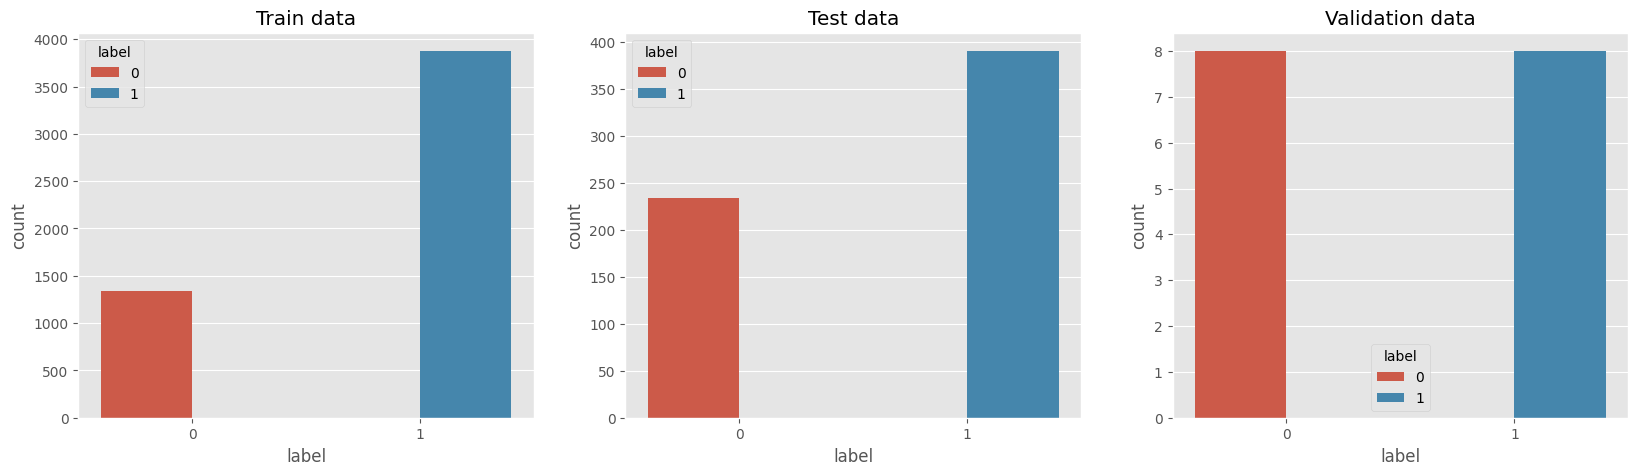

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 5))
plt.style.use('ggplot')

plt.subplot(1, 3, 1)
sns.countplot(data=train_df, x='label', hue='label')
plt.title('Train data')

plt.subplot(1, 3, 2)
sns.countplot(data=test_df, x='label', hue='label')
plt.title('Test data')

plt.subplot(1, 3, 3)
sns.countplot(data=val_df, x='label', hue='label')
plt.title('Validation data')

plt.show()


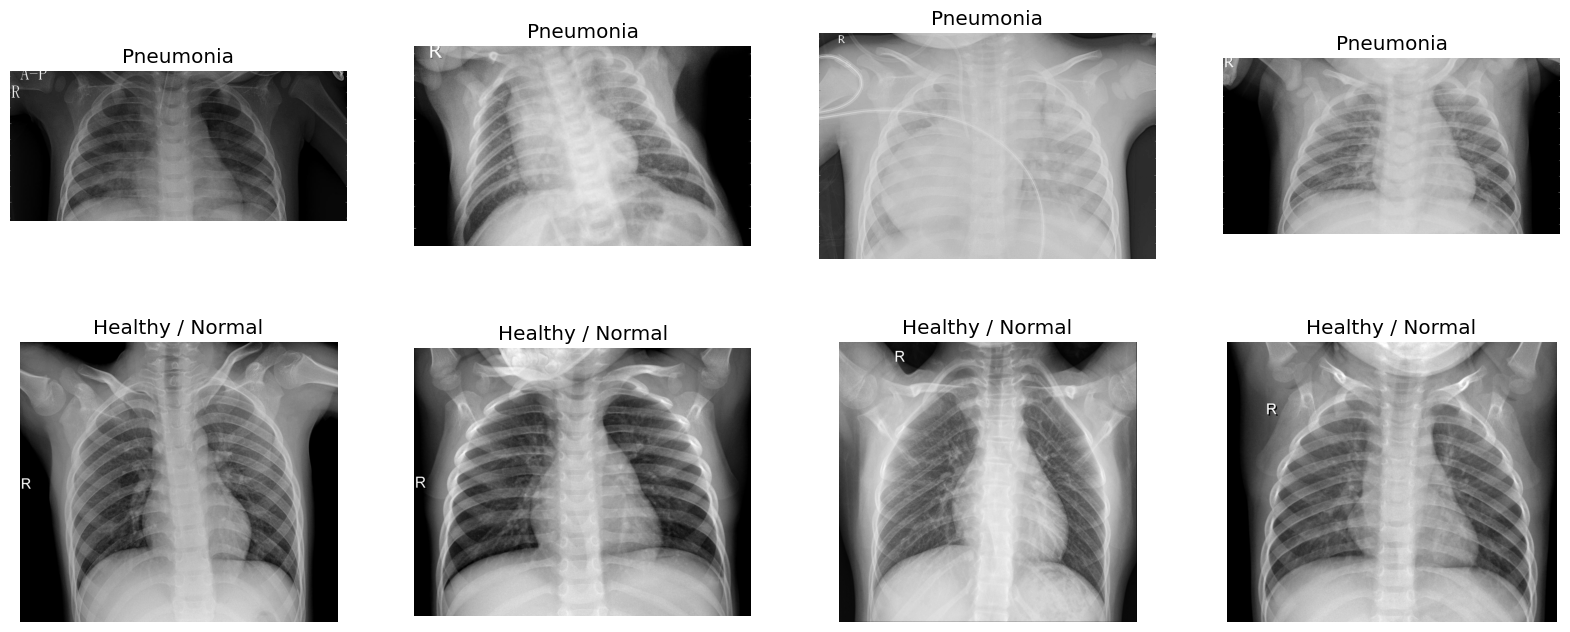

In [8]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Healthy / Normal')

Data preprocessing


In [9]:
def convert_to_grayscale_and_resize_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (127, 127))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (127,127,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(convert_to_grayscale_and_resize_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [10]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 127, 127, 1), Labels shape: (5216,)
Test data shape: (624, 127, 127, 1), Labels shape: (624,)
Validation data shape: (16, 127, 127, 1), Labels shape: (16,)


In [11]:
normal_hist_train = pd.DataFrame(X_train[y_train==0].flatten())
pneumonia_hist_train = pd.DataFrame(X_train[y_train==1].flatten())

normal_hist_valid = pd.DataFrame(X_val[y_val==0].flatten())
pneumonia_hist_valid = pd.DataFrame(X_val[y_val==1].flatten())

normal_hist_test = pd.DataFrame(X_test[y_test==0].flatten())
pneumonia_hist_test = pd.DataFrame(X_test[y_test==1].flatten())

In [12]:


# Definition of train description dataframe
descr_normal_hist_train = normal_hist_train.describe()
descr_pneumonia_hist_train = pneumonia_hist_train.describe()

# Definition of valid description dataframe
descr_normal_hist_valid = normal_hist_valid.describe()
descr_pneumonia_hist_valid = pneumonia_hist_valid.describe()

# Definition of test description dataframe
descr_normal_hist_test = normal_hist_test.describe()
descr_pneumonia_hist_test = pneumonia_hist_test.describe()



In [13]:
print('Some descriptive statistics for \033[1m\033[95mNormal\033[0m class and \033[1m\033[95mTraining\033[0m set are', descr_normal_hist_train)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[95mPneumonia\033[0m class and \033[1m\033[95mTraining\033[0m set are', descr_pneumonia_hist_train)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[36mNormal\033[0m class and \033[1m\033[36mValidation\033[0m set are', descr_normal_hist_valid)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[36mPneumonia\033[0m class and \033[1m\033[36mValidation\033[0m set are', descr_pneumonia_hist_valid)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[93mNormal\033[0m class and \033[1m\033[93mTest\033[0m set are', descr_normal_hist_test)
print(117*'=')
print('Some descriptive statistics for \033[1m\033[93mPneumonia\033[0m class and \033[1m\033[93mTest\033[0m set are', descr_pneumonia_hist_test)
print(117*'=')

Some descriptive statistics for Normal class and Training set are                   0
count  2.162899e+07
mean   4.794404e-01
std    2.468716e-01
min    0.000000e+00
25%    3.176471e-01
50%    5.176471e-01
75%    6.745098e-01
max    1.000000e+00
Some descriptive statistics for Pneumonia class and Training set are                   0
count  6.249988e+07
mean   4.826699e-01
std    2.339494e-01
min    0.000000e+00
25%    3.137255e-01
50%    5.254902e-01
75%    6.745098e-01
max    1.000000e+00
Some descriptive statistics for Normal class and Validation set are                    0
count  129032.000000
mean        0.485002
std         0.269951
min         0.000000
25%         0.278431
50%         0.545098
75%         0.717647
max         1.000000
Some descriptive statistics for Pneumonia class and Validation set are                    0
count  129032.000000
mean        0.494077
std         0.241695
min         0.000000
25%         0.349020
50%         0.556863
75%         0.686275
max      

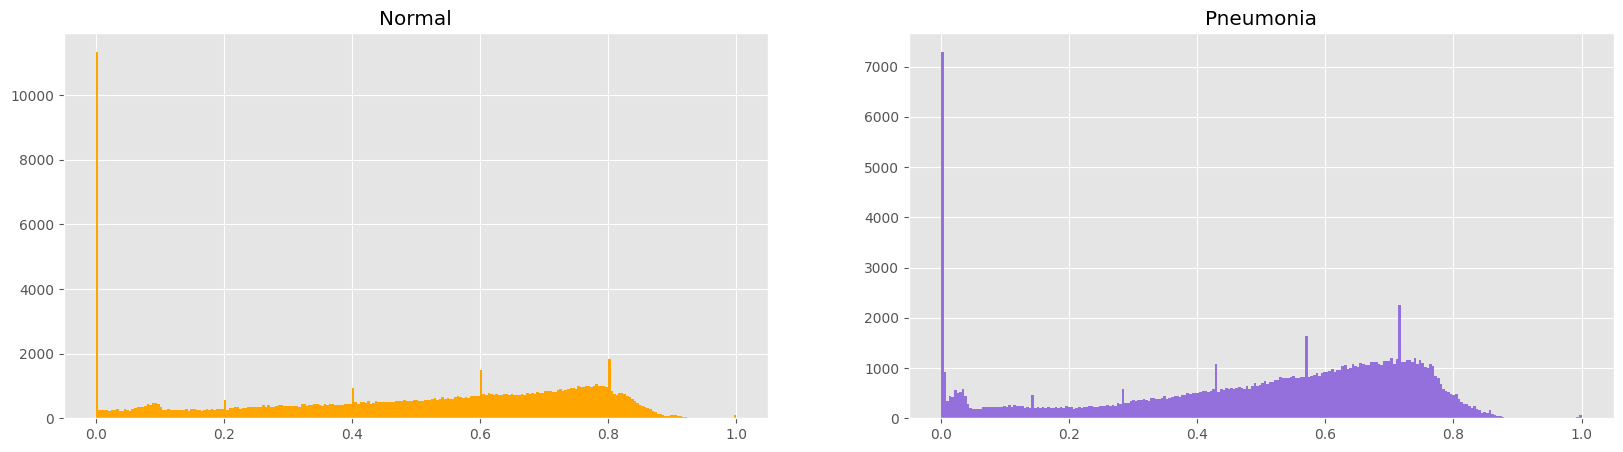

In [14]:
plt.figure(figsize=(20,5))
plt.style.use('ggplot')

normal_flat = normal_hist_valid.values.flatten()
normal_unique_values = np.unique(normal_flat, return_index=False, return_inverse=False, return_counts=True, axis=0)

plt.subplot(1,2,1)
plt.hist(normal_flat, bins=len(normal_unique_values[0]), color = "orange")
plt.title('Normal')

pneumonia_flat = pneumonia_hist_valid.values.flatten()
pneumonia_unique_values = np.unique(pneumonia_flat, return_index=False, return_inverse=False, return_counts=True, axis=0)

plt.subplot(1,2,2)
plt.hist(pneumonia_flat, bins=len(pneumonia_unique_values[0]), color = "mediumpurple")
plt.title('Pneumonia')

plt.show()

In [15]:
reshaped1 = X_train.reshape((X_train.shape[0], 127, 127))

In [16]:
reshaped2 = reshaped1.reshape((X_train.shape[0], 16129))

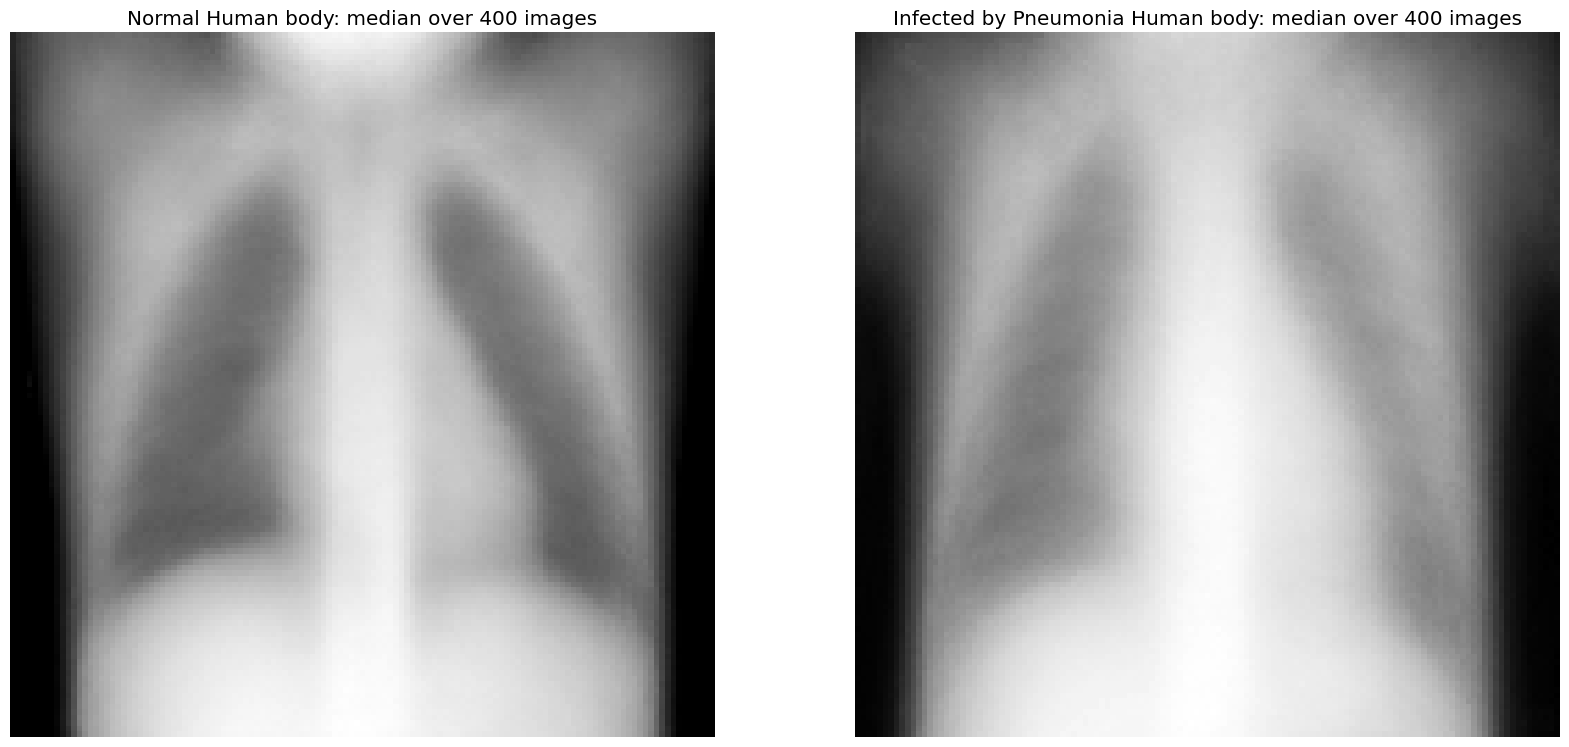

In [17]:
plt.rcParams["figure.figsize"] = (20,18)
ax = plt.subplot(1,2,1)
ax.imshow(pd.DataFrame(reshaped2[y_train==0]).sample(400).median().values.reshape(127,127), cmap='gray')
plt.title('Normal Human body: median over 400 images')
plt.axis("off")

ax2=plt.subplot(1,2,2)
ax2.imshow(pd.DataFrame(reshaped2[y_train==1]).sample(400).median().values.reshape(127,127), cmap='gray')
plt.title('Infected by Pneumonia Human body: median over 400 images')
plt.axis("off")

plt.show()

In [18]:


# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
X_trainFlat.shape



(5216, 16129)

In [19]:


sm = SMOTE(random_state=42)
X_trainsm, Y_trainsm = sm.fit_resample(X_trainFlat, Y_train)



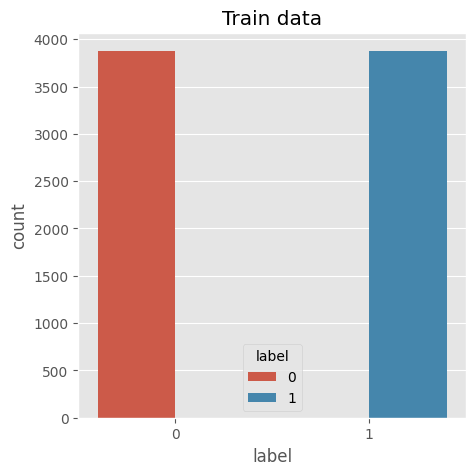

In [20]:
plt.figure(figsize=(5, 5))
plt.style.use('ggplot')

plt.subplot(1, 1, 1)
sns.countplot(data=pd.DataFrame(Y_trainsm, columns=['label']), x='label', hue='label', order=[0, 1])
plt.title('Train data')
plt.show()


Deep Neural Networks


In [21]:
     

concat_train_val_df = pd.concat([train_df, val_df], ignore_index=True)

In [22]:
train_set, val_set = train_test_split(concat_train_val_df, test_size=0.2) #splitting

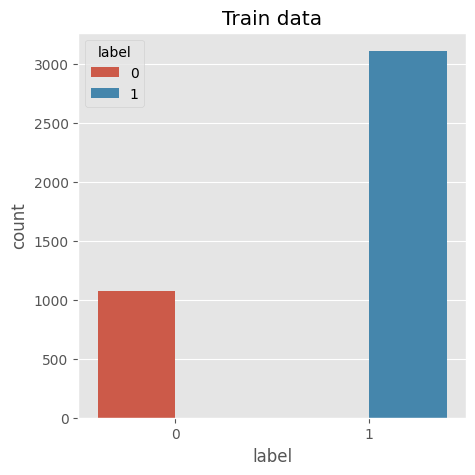

In [23]:
plt.figure(figsize=(5, 5))
plt.style.use('ggplot')

plt.subplot(1, 1, 1)
sns.countplot(data=train_set, x='label', hue='label', order=[0, 1])
plt.title('Train data')
plt.show()



In [24]:
X_train, y_train = compose_dataset(train_set)
X_val, y_val = compose_dataset(val_set)

In [25]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]    # reshape the data sets
X_valShape = X_val.shape[1]*X_val.shape[2]*X_val.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_valFlat = X_val.reshape(X_val.shape[0], X_valShape)
Y_train = y_train
Y_val = y_val

In [26]:
sm = SMOTE(random_state=42)                                      #oversampling

X_trainsm, Y_trainsm = sm.fit_resample(X_trainFlat, Y_train)
X_valsm, Y_valsm = sm.fit_resample(X_valFlat, Y_val)

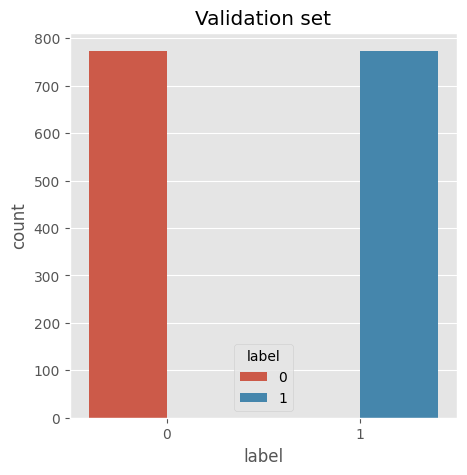

In [27]:
plt.figure(figsize=(5, 5))
plt.style.use('ggplot')

plt.subplot(1, 1, 1)
sns.countplot(data=pd.DataFrame(Y_valsm, columns=['label']), x='label', hue='label', order=[0, 1])
plt.title('Validation set')
plt.show()


In [28]:
X_train_reshaped1=X_trainsm.reshape(X_trainsm.shape[0],127,127) #reshapes
X_valsm_reshaped1=X_valsm.reshape(X_valsm.shape[0],127,127)

In [29]:
X_train_reshaped2=X_train_reshaped1.reshape(X_trainsm.shape[0],127,127,1)          #reshapes
X_valsm_reshaped2=X_valsm_reshaped1.reshape(X_valsm.shape[0],127,127,1)

In [30]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train_reshaped2)


In [31]:
Y_trainsm = to_categorical(Y_trainsm)
y_test = to_categorical(y_test)
Y_valsm = to_categorical(Y_valsm)

Epoch 1/15
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 219s 138ms/step - accuracy: 0.5804 - loss: 0.6551 - val_accuracy: 0.9107 - val_loss: 0.2462
Epoch 2/15
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 263s 139ms/step - accuracy: 0.9055 - loss: 0.2250 - val_accuracy: 0.9373 - val_loss: 0.1650
Epoch 3/15
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 261s 139ms/step - accuracy: 0.9423 - loss: 0.1533 - val_accuracy: 0.9431 - val_loss: 0.1350
Epoch 4/15
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 263s 139ms/step - accuracy: 0.9543 - loss: 0.1269 - val_accuracy: 0.9515 - val_loss: 0.1209
Epoch 5/15
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 263s 140ms/step - accuracy: 0.9575 - loss: 0.1170 - val_accuracy: 0.9515 - val_loss: 0.1204
Epoch 6/15
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 261s 139ms/step - accuracy: 0.9642 - loss: 0.1036 - val_accuracy: 0.9534 - val_loss: 0.1262
Epoch 7/15
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 217s 140ms/step - accuracy: 0.9645 - loss: 0.0922 - val_accuracy: 0.9625 - val_loss: 0.0996
Epoch 8/15
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 262s 140ms/step - ac

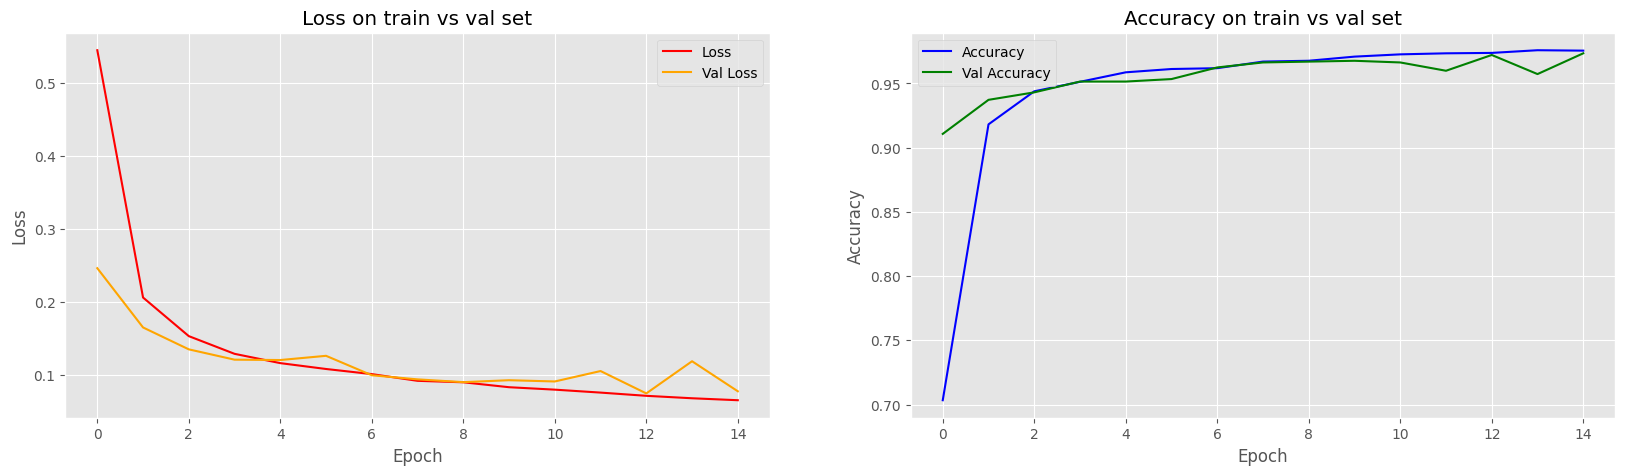

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 127, 127, 8)    │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 127, 127, 8)    │         3,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 962,096 (3.67 MB)

 Trainable params: 320,698 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 641,398 (2.45 MB)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the CNN model
model = Sequential()

# Add convolutional layers and max pooling for feature extraction
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(127, 127, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the feature maps
model.add(Flatten())

# Add fully connected layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))  # Two output units for binary classification

# Compile the model
optimizer = Adam(learning_rate=0.00001)  # Removed the decay argument
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping callback
callback = EarlyStopping(monitor='val_loss', patience=4)

# Assuming you have defined datagen as ImageDataGenerator
datagen = ImageDataGenerator()

# Reshape your data if necessary
# X_train_reshaped2 = ...
# X_valsm_reshaped2 = ...

# Train the model
# Assuming Y_trainsm and Y_valsm are one-hot encoded
history = model.fit(datagen.flow(X_train_reshaped2, Y_trainsm, batch_size=4), 
                    validation_data=(X_valsm_reshaped2, Y_valsm), 
                    callbacks=[callback], 
                    epochs=15)  # You can adjust the number of epochs as needed

# Plotting the training history
plt.figure(figsize=(20, 5))
plt.style.use('ggplot')

# Plot loss and validation loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs val set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Plot accuracy and validation accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs val set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

# Print the model summary
model.summary()



In [33]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


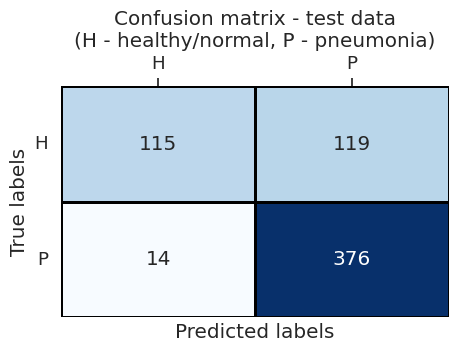

Classification report on test data
              precision    recall  f1-score   support

           0       0.89      0.49      0.63       234
           1       0.76      0.96      0.85       390

    accuracy                           0.79       624
   macro avg       0.83      0.73      0.74       624
weighted avg       0.81      0.79      0.77       624



In [34]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)


Inference module

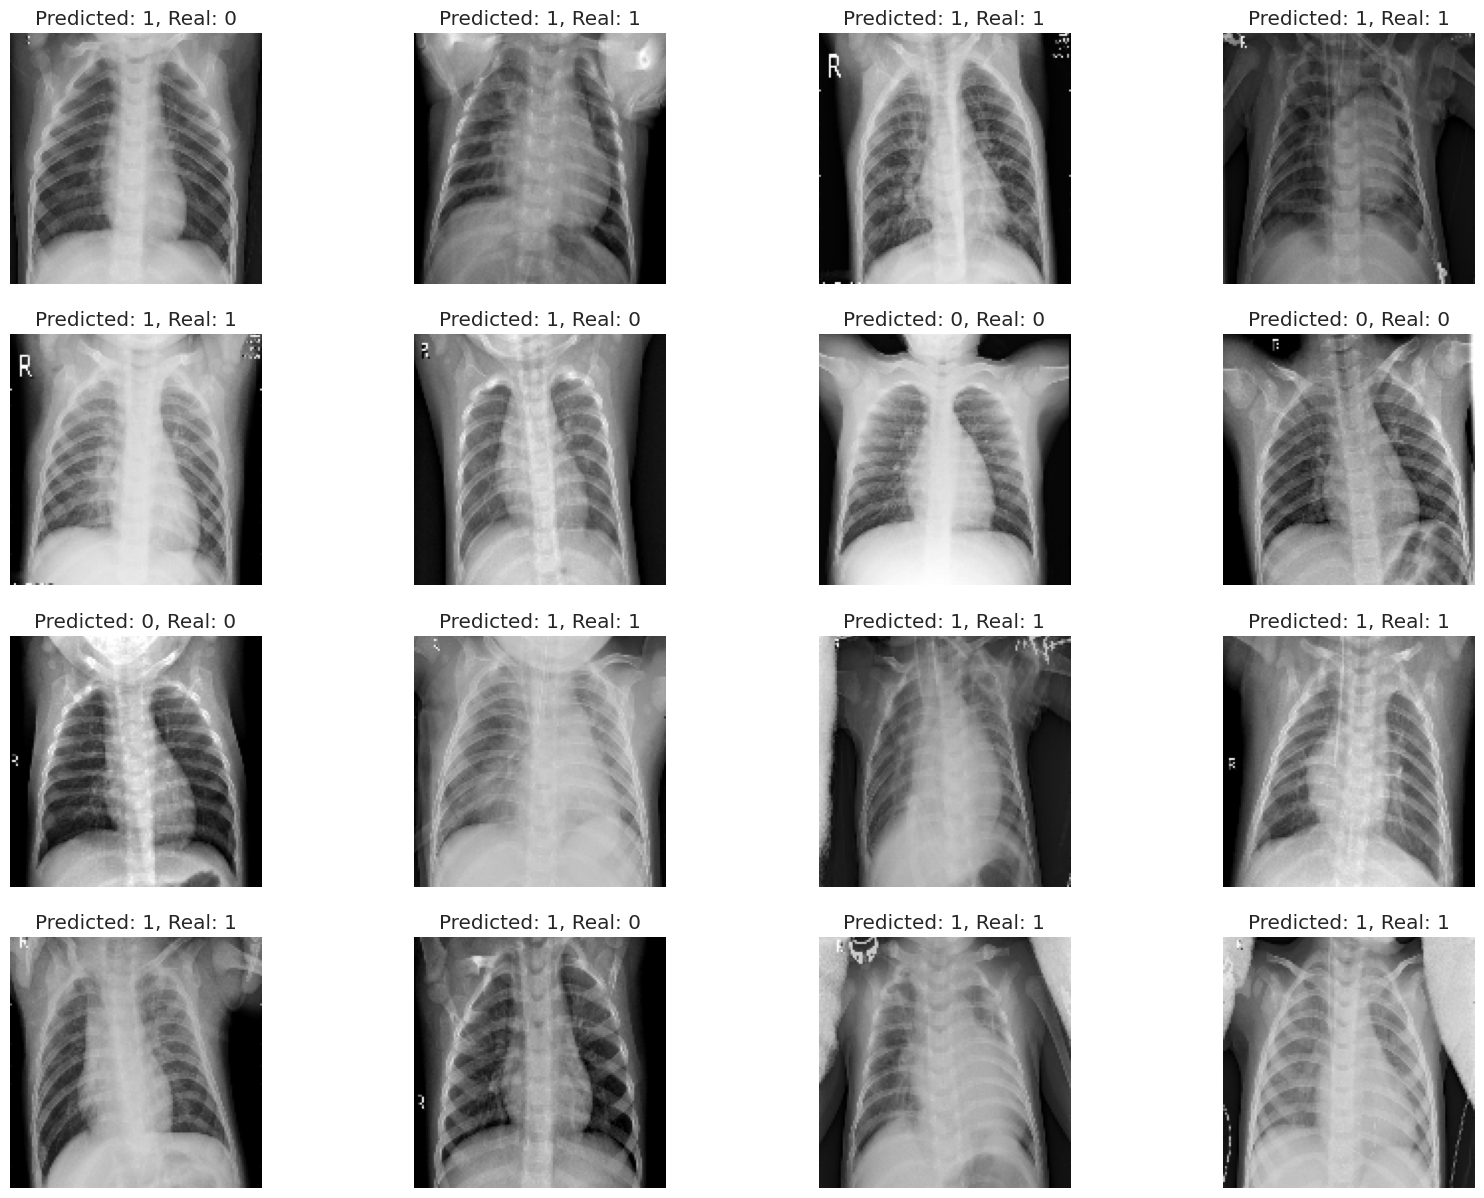

In [35]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_test[0:16]):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(127, 127), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_test_hat[i], y_test[i]))  